In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from scipy import stats
import shap


In [3]:
# Define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Get class names and mappings
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define animal classes
animal_classes = [1, 3, 4, 15, 21, 27, 30, 31, 34, 38, 42, 43, 44, 50, 72, 73, 78, 88, 93, 97]

# Create label mappings
label_to_new_label = {label: idx for idx, label in enumerate(animal_classes)}
new_label_to_class_name = {idx: idx_to_class[label] for label, idx in label_to_new_label.items()}

# Get indices of animal class samples
train_labels = train_dataset.targets
test_labels = test_dataset.targets

animal_train_indices = [i for i, label in enumerate(train_labels) if label in animal_classes]
animal_test_indices = [i for i, label in enumerate(test_labels) if label in animal_classes]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Create custom dataset for animals
class AnimalCIFAR100Dataset(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        new_label = self.label_map[label]
        return img, new_label

# Create animal datasets
train_dataset_animals = AnimalCIFAR100Dataset(Subset(train_dataset, animal_train_indices), label_to_new_label)
test_dataset_animals = AnimalCIFAR100Dataset(Subset(test_dataset, animal_test_indices), label_to_new_label)

# Create data loaders
train_loader = DataLoader(train_dataset_animals, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_animals, batch_size=64, shuffle=False)

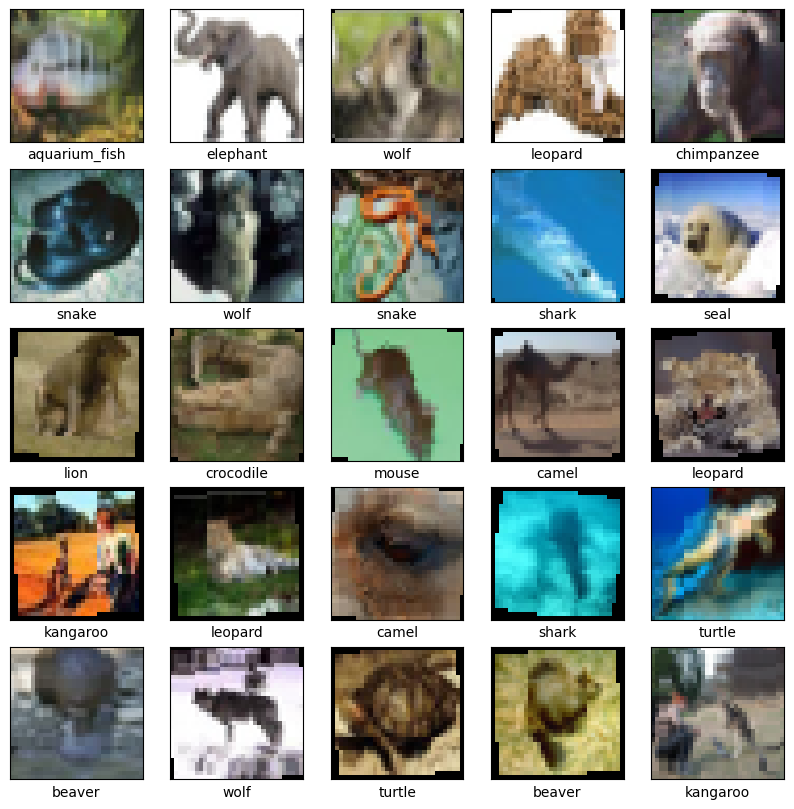

In [5]:
# Visualize some images
images, labels = zip(*[train_dataset_animals[i] for i in range(25)])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.xlabel(new_label_to_class_name[labels[i]])
plt.show()

In [7]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=20):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # Output size: (16, 16)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Output size: (8, 8)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Output size: (4, 4)
        x = self.dropout(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Initialize the model, loss function, and optimizer
model = CNNModel(num_classes=len(animal_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS backend")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA backend")
else:
    device = torch.device('cpu')
    print("Using CPU")
model.to(device)


Using MPS backend


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)

In [8]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/100, Loss: 2.7664
Epoch 2/100, Loss: 2.4822
Epoch 3/100, Loss: 2.3792
Epoch 4/100, Loss: 2.2988
Epoch 5/100, Loss: 2.2556
Epoch 6/100, Loss: 2.2084
Epoch 7/100, Loss: 2.1430
Epoch 8/100, Loss: 2.0830
Epoch 9/100, Loss: 2.0467
Epoch 10/100, Loss: 1.9945
Epoch 11/100, Loss: 1.9521
Epoch 12/100, Loss: 1.9179
Epoch 13/100, Loss: 1.8840
Epoch 14/100, Loss: 1.8634
Epoch 15/100, Loss: 1.8298
Epoch 16/100, Loss: 1.7877
Epoch 17/100, Loss: 1.7536
Epoch 18/100, Loss: 1.7596
Epoch 19/100, Loss: 1.7202
Epoch 20/100, Loss: 1.6999
Epoch 21/100, Loss: 1.6937
Epoch 22/100, Loss: 1.6474
Epoch 23/100, Loss: 1.6356
Epoch 24/100, Loss: 1.6203
Epoch 25/100, Loss: 1.6027
Epoch 26/100, Loss: 1.5810
Epoch 27/100, Loss: 1.5422
Epoch 28/100, Loss: 1.5402
Epoch 29/100, Loss: 1.5160
Epoch 30/100, Loss: 1.4899
Epoch 31/100, Loss: 1.4838
Epoch 32/100, Loss: 1.4601
Epoch 33/100, Loss: 1.4614
Epoch 34/100, Loss: 1.4546
Epoch 35/100, Loss: 1.4412
Epoch 36/100, Loss: 1.4015
Epoch 37/100, Loss: 1.4010
Epoch 38/1

In [58]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.0500


## 95% Confidence Interval

In [59]:
confidence_level = 0.95
Z = stats.norm.ppf((1+confidence_level)/2)
CI = Z * np.sqrt(test_accuracy*(1-test_accuracy)/total)
lb = test_accuracy - CI
ub = test_accuracy + CI

print(f'95% Confidence Interval for model accuracy: {lb*100:.2f} - {ub*100:.2f}')

95% Confidence Interval for model accuracy: 4.04 - 5.96


## Testing a pre-trained model (ResNet) using transfer learning

In [6]:
import torch
from torchvision import models

# Device configuration
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
    print("Using MPS backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using MPS backend


In [22]:
# Model setup (using ResNet18)
model = models.resnet101(pretrained=True)

# Modify for CIFAR-100 images (32x32)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/opt/anaconda3/envs/325-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/325-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/danielmallett/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:10<00:00, 17.8MB/s] 


In [24]:
import time
# Training loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to device with correct dtype
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct.float() / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    print(f'sleeping 10 seconds')
    time.sleep(10)


Epoch 1/10, Loss: 1.0740, Acc: 0.6648
sleeping 10 seconds
Epoch 2/10, Loss: 0.8050, Acc: 0.7448
sleeping 10 seconds
Epoch 3/10, Loss: 0.6314, Acc: 0.7997
sleeping 10 seconds
Epoch 4/10, Loss: 0.4859, Acc: 0.8431
sleeping 10 seconds
Epoch 5/10, Loss: 0.4021, Acc: 0.8715
sleeping 10 seconds
Epoch 6/10, Loss: 0.3282, Acc: 0.8974
sleeping 10 seconds
Epoch 7/10, Loss: 0.1788, Acc: 0.9472
sleeping 10 seconds
Epoch 8/10, Loss: 0.1270, Acc: 0.9655
sleeping 10 seconds
Epoch 9/10, Loss: 0.1066, Acc: 0.9704
sleeping 10 seconds
Epoch 10/10, Loss: 0.0922, Acc: 0.9761
sleeping 10 seconds


### Uncomment this for running a previously saved model

In [ ]:
# # Re-instantiate the model architecture
# model = models.resnet18(pretrained=False)

# # Modify for CIFAR-100 images (32x32)
# model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.maxpool = torch.nn.Identity()

# # Replace the final layer
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, len(animal_classes))

# # Load the saved state dictionary
# model.load_state_dict(torch.load('animal_classifier.pth'))

# # Move the model to the desired device
# model = model.to(device)

# print("Model loaded successfully.")

/opt/anaconda3/envs/325-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/w4/wdxkvy3s2m542rfj2559gqph0000gn/T/ipykernel_2239/3395462161.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

Model loaded successfully.


In [25]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7865


### 95% CI

In [26]:
confidence_level = 0.95
Z = stats.norm.ppf((1+confidence_level)/2)
CI = Z * np.sqrt(test_accuracy*(1-test_accuracy)/total)
lb = test_accuracy - CI
ub = test_accuracy + CI

print(f'95% Confidence Interval for model accuracy: {lb*100:.2f} - {ub*100:.2f}')

95% Confidence Interval for model accuracy: 76.85 - 80.45


# SHAP
https://github.com/fau-masters-collected-works-cgarbin/shap-experiments-image-classification/blob/master/shap-experiments-image-classification.ipynb

In [22]:
model.eval()

data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
sample_images = images[:5]
expl = shap.GradientExplainer(model, images)
sv = expl.shap_values(sample_images)




### Uncomment this if you want to save the model for later use

In [27]:
model_path = 'animal_classifier_resnet101.pth'

# Save the state dictionary

torch.save(model.state_dict(), model_path)

print(f'Model saved to {model_path}')

Model saved to animal_classifier_resnet101.pth


# K-Fold Cross-Validation
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import torch.utils.data.sampler



In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device) 
loss_function = nn.CrossEntropyLoss()
num_splits = 2
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
results = {}

# train
for fold, (train_ids, test_ids) in enumerate(kf.split(train_dataset_animals)):
    print(f'Fold {fold + 1}/{num_splits}')

    train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.sampler.SubsetRandomSampler(test_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset_animals, batch_size=10, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(train_dataset_animals, batch_size=10, sampler=test_subsampler)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(0, 1):
        print(f'epoch {epoch}')
        current_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)  # Move both inputs and targets to the same device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
                current_loss = 0.0

    # evaluate
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (pred == targets).sum().item()    
            #print(f'accuracy for fold {fold}: {100.0 * correct/total}')
            results[fold] = 100.0 * (correct / total)
        
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

Fold 1/5
epoch 0
Loss after mini-batch   500: 0.072
epoch 1
Loss after mini-batch   500: 0.076
epoch 2
Loss after mini-batch   500: 0.043
epoch 3
Loss after mini-batch   500: 0.078
epoch 4
Loss after mini-batch   500: 0.066
epoch 5
Loss after mini-batch   500: 0.070
epoch 6
Loss after mini-batch   500: 0.067
epoch 7
Loss after mini-batch   500: 0.061
epoch 8
Loss after mini-batch   500: 0.068
epoch 9
Loss after mini-batch   500: 0.064
epoch 10
Loss after mini-batch   500: 0.079
epoch 11
Loss after mini-batch   500: 0.083
epoch 12
Loss after mini-batch   500: 0.064
epoch 13
Loss after mini-batch   500: 0.065
epoch 14
Loss after mini-batch   500: 0.051
epoch 15
Loss after mini-batch   500: 0.054
epoch 16
Loss after mini-batch   500: 0.059
epoch 17
Loss after mini-batch   500: 0.051
epoch 18
Loss after mini-batch   500: 0.067
epoch 19
Loss after mini-batch   500: 0.071
epoch 20
Loss after mini-batch   500: 0.084
epoch 21
Loss after mini-batch   500: 0.064
epoch 22
Loss after mini-batch   

# Testing on Custom Photos

In [28]:
import os
from PIL import Image
import math

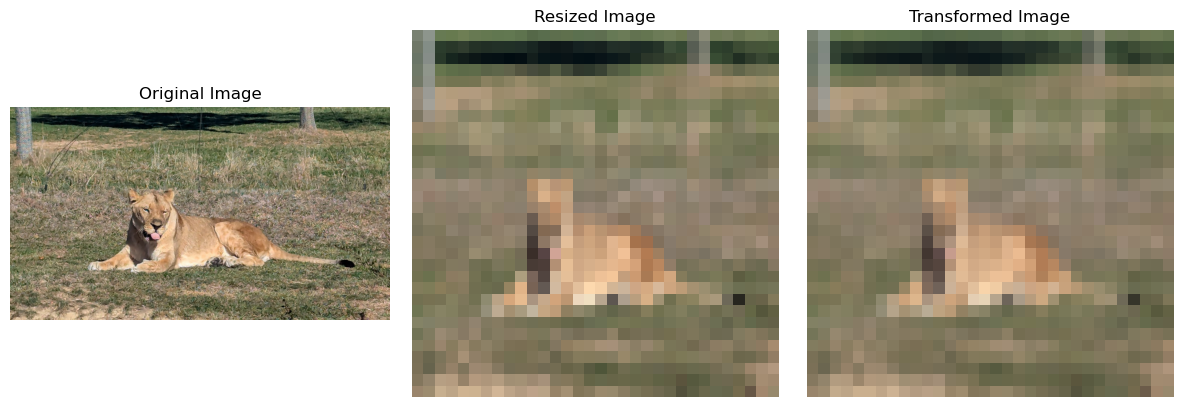

In [29]:
image_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 28x28
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Normalize to match training data
    #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize RGB channels
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transformed_image = image_transform(image).unsqueeze(0)  # Flatten for model input
    return transformed_image

def visualize_image_transform(image_path):
    image = Image.open(image_path)

    # Original Image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # After resizing
    image_resized = image.resize((32, 32))
    plt.subplot(1, 3, 2)
    plt.imshow(image_resized, cmap='gray')
    plt.title('Resized Image')
    plt.axis('off')

    # After applying transformations (ToTensor and Normalize)
    transformed_image = image_transform(image).squeeze().numpy()  # Squeeze to remove channel dimension for display
    transformed_image = transformed_image.transpose(1,2,0)
    plt.subplot(1, 3, 3)
    plt.imshow(transformed_image)
    plt.title('Transformed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_image_transform('images/lion.jpg')

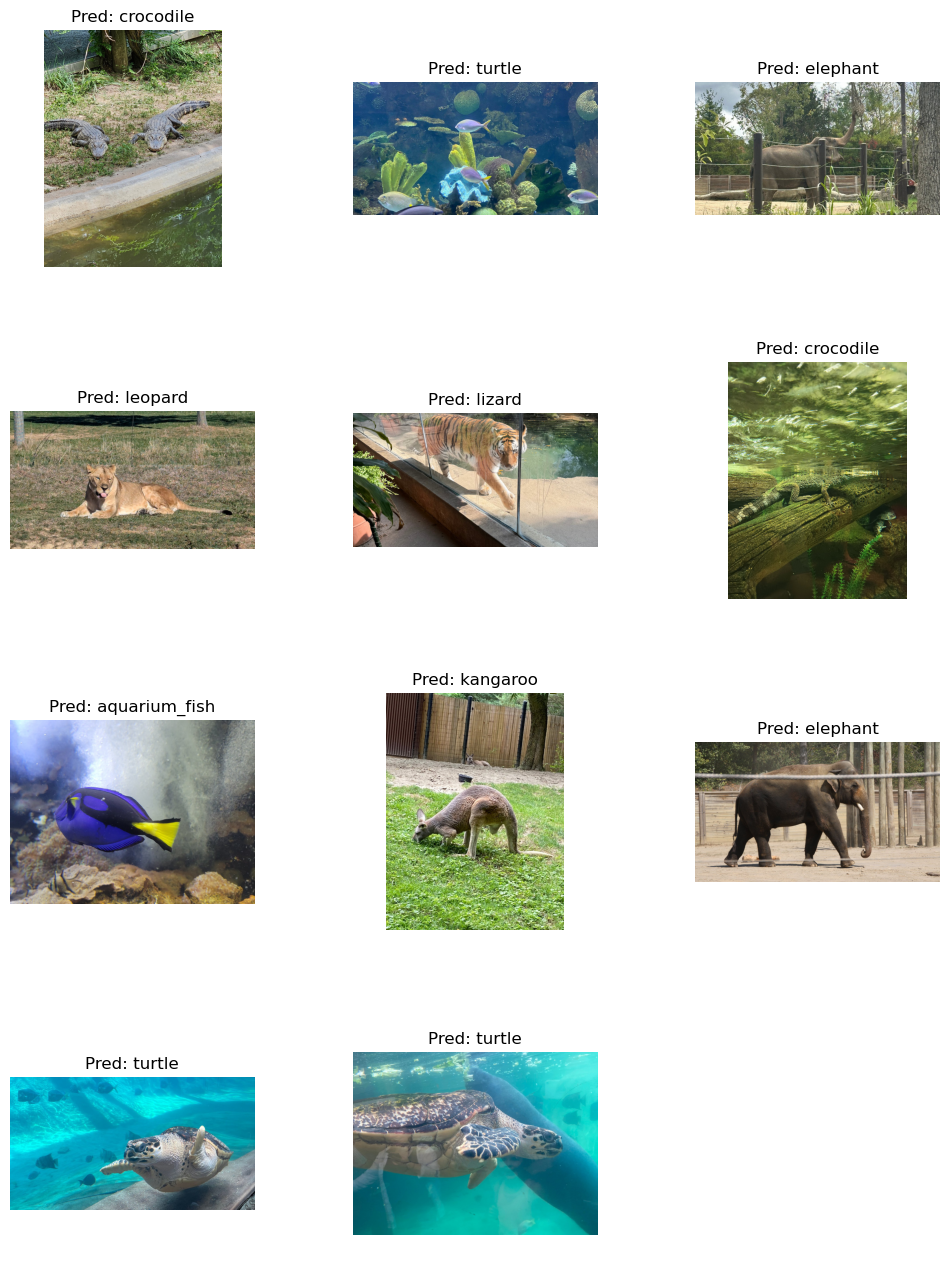

In [31]:

def test_model_on_custom_images(model, folder_path, device):
    # Get image files
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]
    num_images = len(image_files)

    # Calculate grid size (rows and columns)
    cols = 3  # Number of columns
    rows = math.ceil(num_images / cols)  # Dynamically calculate rows
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size dynamically
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Iterate over image files
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        input_image = load_and_preprocess_image(image_path).to(device)

        # Model inference
        with torch.no_grad():
            output = model(input_image)
            predicted_label = torch.argmax(output, dim=1).item()  # Get the predicted class label

        # Display image and prediction
        ax = axes[i]
        ax.imshow(Image.open(image_path))
        #ax.set_title(f'Pred: {predicted_label}')
        ax.set_title(f'Pred: {new_label_to_class_name[predicted_label]}')
        ax.axis('off')

    # Turn off unused axes
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')

    plt.show()


test_model_on_custom_images(model, './images', device)
